TensorFlow: 2.4.1
Uploaded file path (if you want to show or link it): /mnt/data/c6688583-8793-4652-ab2e-38ae7658d278.png
Shapes: (55000, 28, 28, 1) (55000,) (5000, 28, 28, 1) (10000, 28, 28, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
______________________________________________________________

C:\Users\91861\anaconda3\envs\dlc\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\91861\anaconda3\envs\dlc\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE done. Shape: (2000, 2)


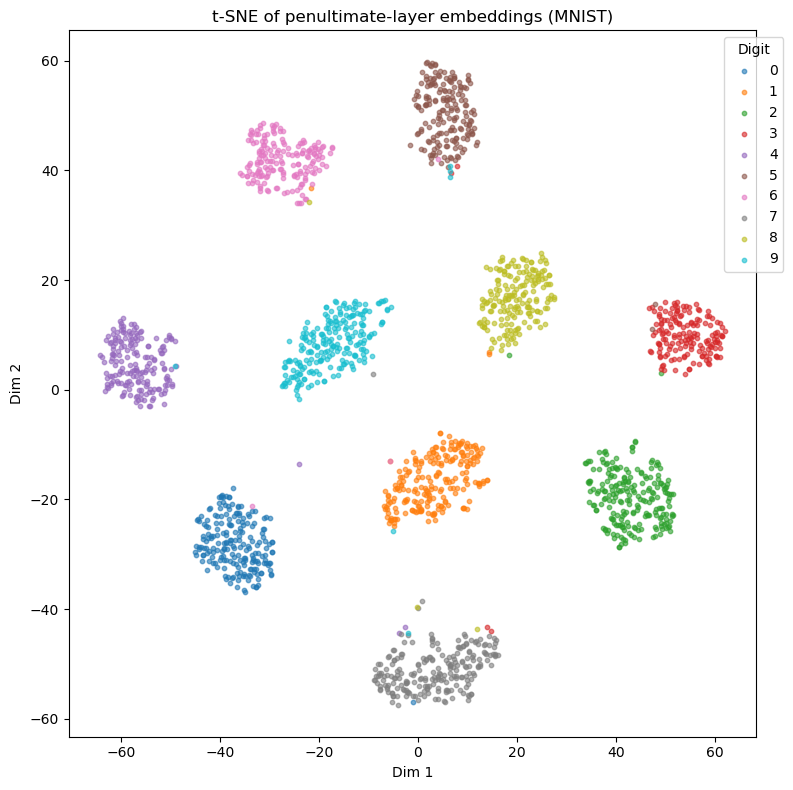

Saved t-SNE plot to mnist_tsne_output\mnist_embeddings_tsne.png


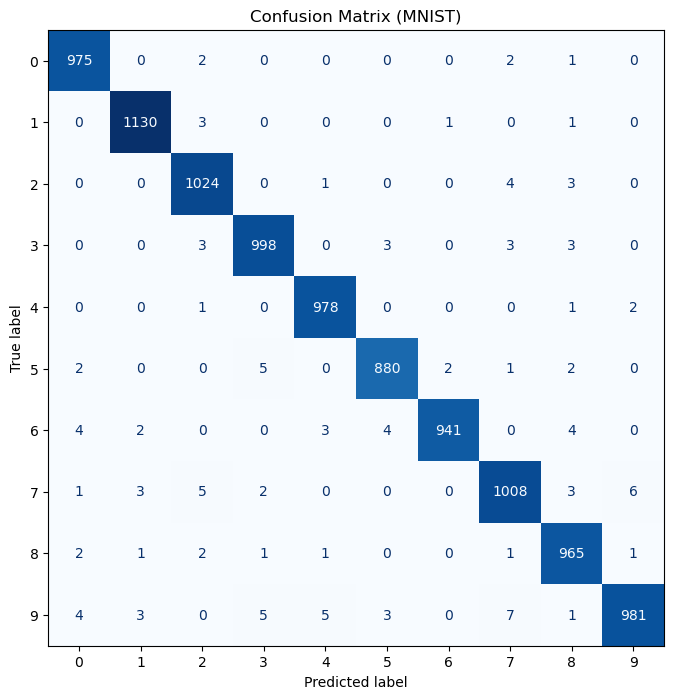

Saved confusion matrix to mnist_tsne_output\mnist_confusion_matrix.png
Total misclassified: 120 (showing up to 9)


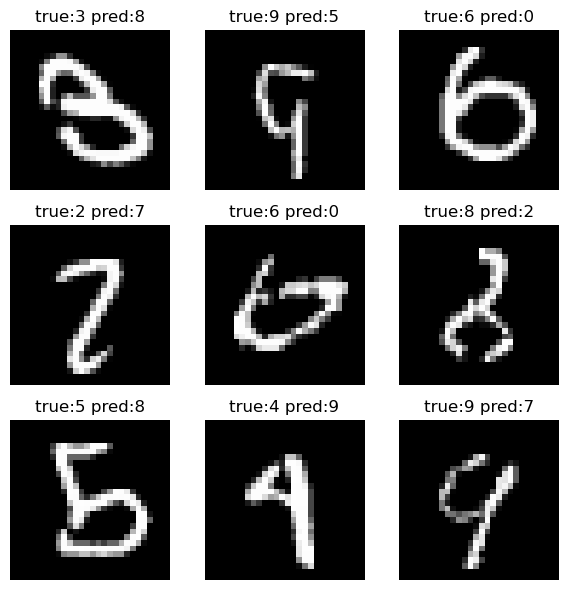

Saved misclassified gallery to mnist_tsne_output\mnist_misclassified.png
Saved model to mnist_tsne_output\mnist_embedding_model.h5

Outputs saved in folder: mnist_tsne_output
 - t-SNE plot: mnist_tsne_output\mnist_embeddings_tsne.png
 - confusion matrix: mnist_tsne_output\mnist_confusion_matrix.png
 - misclassified gallery: mnist_tsne_output\mnist_misclassified.png
 - saved model: mnist_tsne_output\mnist_embedding_model.h5


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

print("TensorFlow:", tf.__version__)

# Optional: path to your uploaded screenshot (included here)
UPLOADED_FILE = "/mnt/data/c6688583-8793-4652-ab2e-38ae7658d278.png"
print("Uploaded file path (if you want to show or link it):", UPLOADED_FILE)

# 1) Load MNIST (built-in)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Normalize, expand dims
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

# Keep small validation set for quick runs
val_split = 5000
x_val, y_val = x_train[-val_split:], y_train[-val_split:]
x_train, y_train = x_train[:-val_split], y_train[:-val_split]

print("Shapes:", x_train.shape, y_train.shape, x_val.shape, x_test.shape)

# 2) Model: tiny CNN with a small embedding vector (penultimate Dense)
def build_model(embedding_dim=32):
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(16, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim, activation='relu', name='embedding')(x)  # embedding layer
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(embedding_dim=64)
model.summary()

# 3) Train quickly
EPOCHS = 6
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=128,
    verbose=2
)

# 4) Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}  loss: {test_loss:.4f}")

# 5) Extract embeddings for test set (output of 'embedding' layer)
embedding_model = models.Model(inputs=model.input, outputs=model.get_layer('embedding').output)
embeddings = embedding_model.predict(x_test)  # shape: (num_test, embedding_dim)
print("Embeddings shape:", embeddings.shape)

# 6) Run t-SNE to reduce to 2D for visualization (use a subset for speed)
SUBSET = 2000  # reduce for speed; set to len(x_test) if you want full
idxs = np.random.choice(len(embeddings), SUBSET, replace=False)
emb_sub = embeddings[idxs]
labels_sub = y_test[idxs]

print("Running t-SNE (this may take ~20-60s depending on machine)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, init='pca')
emb2d = tsne.fit_transform(emb_sub)
print("t-SNE done. Shape:", emb2d.shape)

# 7) Plot t-SNE scatter, colored by true label
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('tab10')
for d in range(10):
    sel = labels_sub == d
    plt.scatter(emb2d[sel,0], emb2d[sel,1], label=str(d), alpha=0.6, s=10)
plt.legend(title="Digit", bbox_to_anchor=(1.05,1))
plt.title("t-SNE of penultimate-layer embeddings (MNIST)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
out_dir = "mnist_tsne_output"
os.makedirs(out_dir, exist_ok=True)
tsne_path = os.path.join(out_dir, "mnist_embeddings_tsne.png")
plt.savefig(tsne_path, dpi=150)
plt.show()
print("Saved t-SNE plot to", tsne_path)

# 8) Confusion matrix on test set
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix (MNIST)")
plt.savefig(os.path.join(out_dir, "mnist_confusion_matrix.png"), dpi=150)
plt.show()
print("Saved confusion matrix to", os.path.join(out_dir, "mnist_confusion_matrix.png"))

# 9) Show a small gallery of misclassified examples (up to 9)
mis_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(mis_idx)} (showing up to 9)")
sample_mis = mis_idx[:9]
fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, i in zip(axes.flatten(), sample_mis):
    ax.imshow(x_test[i].squeeze(), cmap='gray')
    ax.set_title(f"true:{y_test[i]} pred:{y_pred[i]}")
    ax.axis('off')
plt.tight_layout()
mis_path = os.path.join(out_dir, "mnist_misclassified.png")
plt.savefig(mis_path, dpi=150)
plt.show()
print("Saved misclassified gallery to", mis_path)

# 10) Save model and small README text for your GitHub
model_path = os.path.join(out_dir, "mnist_embedding_model.h5")
model.save(model_path)
print("Saved model to", model_path)

# END - print summary for README
print("\nOutputs saved in folder:", out_dir)
print(" - t-SNE plot:", tsne_path)
print(" - confusion matrix:", os.path.join(out_dir, "mnist_confusion_matrix.png"))
print(" - misclassified gallery:", mis_path)
print(" - saved model:", model_path)

# Quick helper: predict a single image (normalized 28x28)
def predict_single(img_array):
    a = img_array.copy()
    if a.ndim == 2: a = a[..., np.newaxis]
    a = np.expand_dims(a, axis=0)
    p = model.predict(a)[0]
    return np.argmax(p), np.max(p)

# Example usage:
# idx = 0
# print("True:", y_test[idx], "Pred,Conf:", predict_single(x_test[idx]))
